<div class="jumbotron text-left"><b>
    
This tutorial describes how to use the SMT toolbox to do some Bayesian Optimization (MOO method) to solve multi-objective unconstrained optimization problem
<div>
    
Robin Grapin - 2021
    
https://github.com/RobinGRAPIN?tab=repositories

# Problem definition

Let us go with a 2-objectives function from a 2-D variable. Feel free to choose the objectives within the SMT Problems and to change the bounds.

In [3]:
from platform import python_version
print(python_version()) #python version has to be > 3.6 to use pymoo
import sys
!pip install pymoo smt smoot

3.9.4
  Using cached pymoo-0.4.2.2-cp39-cp39-win_amd64.whl (4.2 MB)
  Using cached smt-1.0.0-cp39-cp39-win_amd64.whl
  Using cached smoot-0.0.2.tar.gz (5.2 kB)
  Using cached scipy-1.6.3-cp39-cp39-win_amd64.whl (32.7 MB)
  Using cached cma-2.7.0-py2.py3-none-any.whl (239 kB)
  Using cached matplotlib-3.4.1-cp39-cp39-win_amd64.whl (7.1 MB)
  Using cached numpy-1.20.2-cp39-cp39-win_amd64.whl (13.7 MB)
  Using cached autograd-1.3.tar.gz (38 kB)
  Using cached future-0.18.2.tar.gz (829 kB)
  Using cached kiwisolver-1.3.1-cp39-cp39-win_amd64.whl (51 kB)
  Using cached Pillow-8.2.0-cp39-cp39-win_amd64.whl (2.2 MB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)
  Using cached pyDOE2-1.3.0.tar.gz (19 kB)
  Using cached numpydoc-1.1.0-py3-none-any.whl (47 kB)
  Using cached Sphinx-3.5.4-py3-none-any.whl (2.8 MB)
  Using cached alabaster-0.7.12-py2.py3-none-any.whl (14 kB)
  Using cached snowballstemmer-2.1.0-py2.py3-none-any.whl (93 kB)
  Using cached docutils-0.16-py2.py3-none-any.

In [4]:
#imports
import numpy as np
from random import randint
import matplotlib.pyplot as plt

from smt.problems import Rosenbrock, Branin
from smt.sampling_methods import LHS
from smt.surrogate_models import LS, QP, KPLS, KRG, KPLSK, GEKPLS, MGP

from pymoo.algorithms.nsga2 import NSGA2
from pymoo.model.problem import Problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

In [5]:
#problem definition
ndim = 2
ny = 2
fun1 = Rosenbrock(ndim=ndim)
fun2 = Branin(ndim=ndim)

#function to minimize
def objective(x):
    return [fun1(x), fun2(x)]
    
xlimits = np.array([[-2.0,2.0], [-2.0,2.0]])

<ipython-input-6-468065f758e0>:14: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


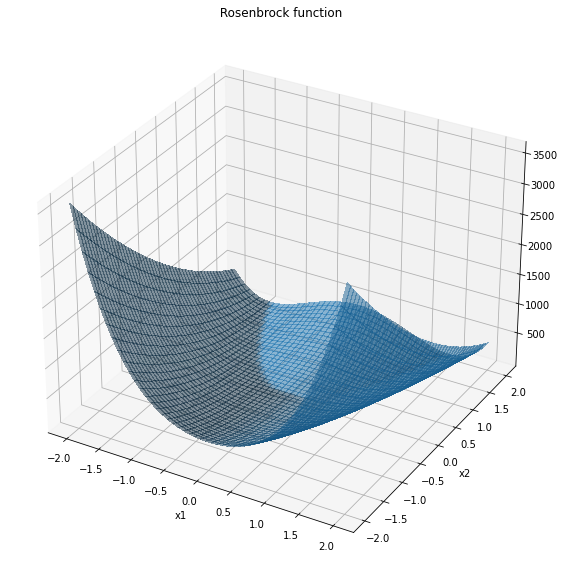

<ipython-input-6-468065f758e0>:29: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


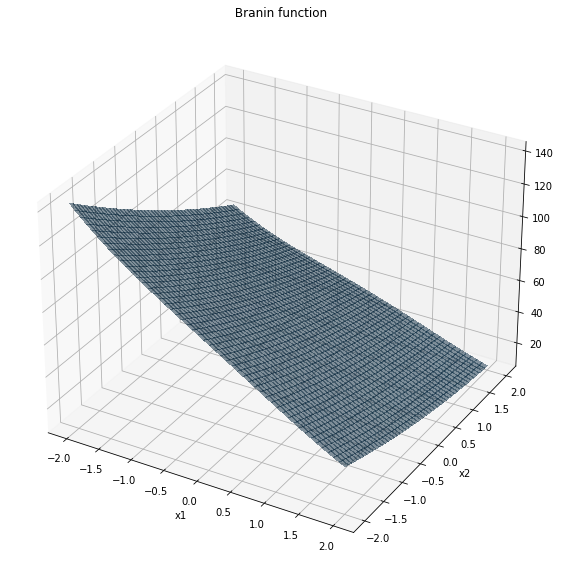

In [6]:
#plot of objective functions
%matplotlib inline
#To plot the Rosenbrock function
num_plot = 50 #to plot rosenbrock
x = np.linspace(xlimits[0][0],xlimits[0][1],num_plot)
res = []
for x0 in x:
    for x1 in x:
        res.append(fun1(np.array([[x0,x1]])))
res = np.array(res)
res = res.reshape((50,50)).T
X,Y = np.meshgrid(x,x)
fig = plt.figure(figsize=[10,10])
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, res,
                       linewidth=0, antialiased=False,alpha=0.5)
plt.title(' Rosenbrock function')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

res2 = []
for x0 in x:
    for x1 in x:
        res2.append(fun2(np.array([[x0,x1]])))
res2 = np.array(res2)
res2 = res2.reshape((50,50)).T
fig = plt.figure(figsize=[10,10])
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, res2,
                       linewidth=0, antialiased=False,alpha=0.5)
plt.title(' Branin function')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

# Real Pareto front

The goal in multi-objective optimization is to find a set of points dominated by no others. To see the Pareto front of our function, let's run the genetic algorithm NSGA2 on it, without using surrogates. This will serve for comparition later.

n_gen |  n_eval |  n_nds  |     eps      |  indicator  
    1 |     100 |       7 |            - |            -
    2 |     200 |      10 |  0.048512864 |        ideal
    3 |     300 |      13 |  0.063567065 |        ideal
    4 |     400 |      16 |  0.013962172 |        ideal
    5 |     500 |      21 |  0.037321155 |            f
    6 |     600 |      27 |  0.032217709 |        ideal
    7 |     700 |      33 |  0.012048377 |            f
    8 |     800 |      38 |  0.003363461 |        ideal
    9 |     900 |      43 |  0.003377972 |        ideal
   10 |    1000 |      52 |  0.025269460 |        nadir
   11 |    1100 |      69 |  0.032579274 |        nadir
   12 |    1200 |      78 |  0.005820871 |        nadir
   13 |    1300 |      95 |  0.019093281 |        nadir
   14 |    1400 |     100 |  0.160239534 |        nadir
   15 |    1500 |     100 |  0.003087440 |        nadir
   16 |    1600 |     100 |  0.000780646 |            f
   17 |    1700 |     100 |  0.001107905 |      

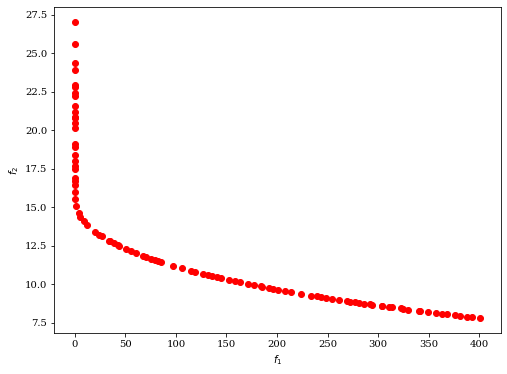

In [7]:
#creation of a Pymoo problem to be able to use NSGA2 on it
class MyProblem_reel(Problem):

    def __init__(self):
        super().__init__(n_var=2,
                         n_obj=2,
                         n_constr=0,
                         xl=np.array([-2.0, -2.0]),
                         xu=np.array([2.0, 2.0]),
                         elementwise_evaluation=True)

    def _evaluate(self, x, out, *args, **kwargs):
        xx = np.asarray(x).reshape(1, -1) #Our functions take array as entry
        f1 = fun1(xx)[0][0]
        f2 = fun2(xx)[0][0]
        out["F"] = [f1, f2]
        #out["G"] = [g1, g2] #no constraints at the moment

problem_exact = MyProblem_reel()

algorithm_bis = NSGA2(pop_size=100)

res_exact = minimize(problem_exact,
               algorithm_bis,
               ("n_gen", 100),
               verbose=True, #False if you do not want the text
               seed=1)

plot = Scatter()
plot.add(res_exact.F, color="red")
plot.show()

# Using a surrogate model

As the objective function might be expensive to call, using genetic algorithm on it can be very long. This is why MOO is used to :

 1) create a model withe the Krige method  
 2) refine the by model chosing cleverly the points to evaluate  
 3) running NSGA2 on a good model to obtain the Pareto set and front  

In [8]:
from smoot import MOO

#creation of a MOO object
mo = MOO(n_iter = 10, #added points to refine the model
         n_start = 20, #points for the initial sampling (default sampling method : LHS)
         xlimits = xlimits, 
         verbose = True, #to know what is happening during the run
         n_gen=50, #number of generations for the genetic algorithm
         pop_size = 50)#number of new individuals at every generation of NSGA2

iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
Model is well refined, NSGA2 is running...
n_gen |  n_eval |  n_nds  |     eps      |  indicator  
    1 |      50 |       2 |            - |            -
    2 |     100 |       5 |  0.530608597 |        ideal
    3 |     150 |       5 |  0.027504974 |            f
    4 |     200 |      13 |  0.478942526 |        nadir
    5 |     250 |      16 |  0.096223456 |        ideal
    6 |     300 |      16 |  0.034653360 |        ideal
    7 |     350 |      17 |  0.003432460 |        nadir
    8 |     400 |      26 |  0.006259960 |        ideal
    9 |     450 |      33 |  0.023748132 |            f
   10 |     500 |      32 |  0.006976765 |        ideal
   11 |     550 |      44 |  0.003018368 |        nadir
   12 |     600 |      49 |  0.003409862 |            f
   13 |     650 |      50 |  0.003093301 |        ideal
   14 |     700 |      50 |  0.002712844 |          

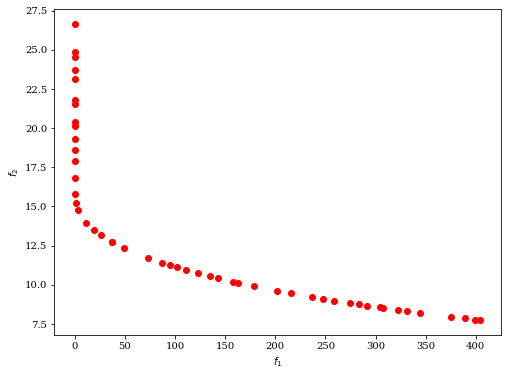

In [9]:
#optimization
mo.optimize(objective)

#vizualization of the Pareto front
res = mo.result
plot = Scatter()
plot.add(res.F, color="red")
plot.show()

<div>In this example, the objective function <code>objective</code> has been called <i>n_start + n_iter</i> times. </div>
We can see that the obtained front is close from the one obtained without using surrogates. You can now play with the function to optimize <code>objective</code>, the bounds <code>xlimits</code>, but also the parameters of MOO itself. For example, when defining the MOO object, you can declare <code>surrogate =</code> to choose a different modelization kernel or <code>criterion =</code> for a different activation function in the model's refining loop.

## Method comparition

One of the crucial points of bayesian optimization is the way the points are iteratively selected to improve the surrogate model. Here, we will compare the efficiency of the differents model's improvement methods. The benchmark functions will be the ZDT functions from Zitzler et al. Their Pareto optima is given by an explicit formulae, what allows to mesure the pecision of our results. 

In [10]:
from smt.sampling_methods import LHS
from smoot import ZDT
import time

ndim =2
benchmark = [ZDT(type = 1,ndim = ndim),ZDT(type = 2,ndim = ndim),ZDT(type = 3,ndim = ndim)]
n_start = 10
xlimits = benchmark[0].xlimits
n_start = 10 #small to augment the importance of the criterion
n_iter = 10

#scalarized problem
points = 10 #values of alpha for the scalarized problem
alphas = np.linspace(0,1,points)

# setup of solvers using different methods
ego = MOO(n_iter=n_iter, n_start = n_start, xlimits=xlimits) #for scalarization. EGO is called by MOO when only 1 objective
moga = MOO(n_iter = n_iter,criterion = "GA", n_start = n_start, xlimits = xlimits, n_gen=30, pop_size = 30)
mopi = MOO(n_iter = n_iter,criterion = "PI", n_start = n_start, xlimits = xlimits, n_gen=50, pop_size = 50)
moei = MOO(n_iter = n_iter,criterion = "EHVI", n_start = n_start, xlimits = xlimits, n_gen=50, pop_size = 50)
mowb = MOO(n_iter = n_iter,criterion = "WB2S", n_start = n_start, xlimits = xlimits, n_gen=50, pop_size = 50)

In [13]:
# run the optimizations with each method on each function
yscal, ypi, yga, yei, ywb, ytrue = [],[],[],[],[],[]
for zdt in benchmark:
    print("Loop for function ZDT %s" % zdt.options["type"])    
    start_time = time.time()
    
    pts_scalar, i = np.zeros((points, ndim)),0
    for alpha in alphas :
        ego.optimize(lambda x: alpha*zdt(x)[0] + (1-alpha)*zdt(x)[1])
        pts_scalar[i]=ego.result.X
    yscal.append(zdt(pts_scalar))
    ego_time = time.time()
    print("ego method finished in",ego_time - start_time,"seconds for", points,"points" )
    
    mopi.optimize(zdt)
    ypi.append( np.array(mopi.result.F) )
    pi_time = time.time()
    print("PI method finished in",pi_time - ego_time,"seconds")
    
    moga.optimize(zdt)
    yga.append( np.array(moga.result.F) )
    ga_time = time.time()
    print("GA method finished in",ga_time - pi_time,"seconds")
    
    moei.optimize(zdt)
    yei.append( np.array(moei.result.F) )
    ei_time = time.time()
    print("EHVI method finished",ei_time - ga_time,"seconds")
    
    mowb.optimize(zdt)
    ywb.append( np.array(mowb.result.F) )
    wb_time = time.time()
    print("WB2S method finished",wb_time - ei_time,"seconds \n")
    
    _,y = zdt.pareto(300)
    ytrue.append(y)

Loop for function ZDT 1
ego method finished in 50.4717812538147 seconds for 10 points
PI method finished in 4.1043479442596436 seconds
GA method finished in 9.849114894866943 seconds
EHVI method finished 3.825535535812378 seconds
WB2S method finished 608.9566366672516 seconds 

Loop for function ZDT 2
ego method finished in 42.7205023765564 seconds for 10 points
PI method finished in 3.504149913787842 seconds
GA method finished in 7.732548952102661 seconds
EHVI method finished 7.998586416244507 seconds
WB2S method finished 190.43241381645203 seconds 

Loop for function ZDT 3
ego method finished in 49.92816162109375 seconds for 10 points
PI method finished in 4.791743516921997 seconds
GA method finished in 9.813454389572144 seconds
EHVI method finished 35.28376483917236 seconds
WB2S method finished 37.53007793426514 seconds 



### Distance function

Usual indicators of similarity cannot conciliate the 3 criterias that make of an algorithm output a good approximation of the Pareto front : 
 - The proximity with the real values to take
 - The number of points
 - The repartition of the points across the variety of the possible values

The indicator that is used here takes in account these 3 factors by creating a kridge model with the obtained points. Then, the distance between the model's mean and the real front can be measured in random points, not only those obtained. This way, if the amount of points is too low or if they do not well cover the objective space, the model will not be very accurate.

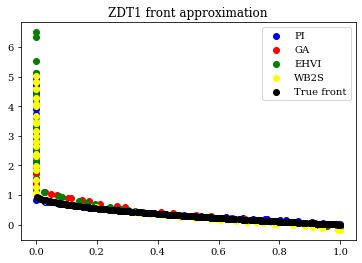

distance scalarized to true front 0.4305608345059756
distance PI to true front 0.024003589940788897
distance GA to true front 0.05728113583995989
distance EHVI to true front 0.03465701721274064
distance WB2S to true front 0.04351471402892791


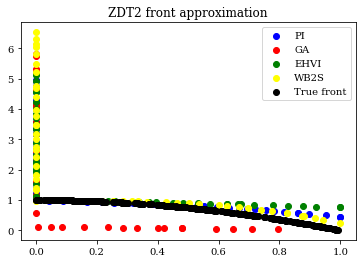

distance scalarized to true front 0.6055303900711283
distance PI to true front 0.10026429338028157
distance GA to true front 0.431453575446626
distance EHVI to true front 0.20085080769163724
distance WB2S to true front 0.12101743488754385


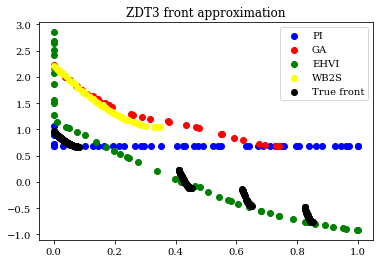

distance scalarized to true front 0.6647952752314674
distance PI to true front 0.3603219178517944
distance GA to true front 0.5174091364972807
distance EHVI to true front 0.012998816820018088
distance WB2S to true front 0.7240501431038993


In [12]:
def ecart_front(y1,y2,fun,pts = 200):
    """
        For a 2-objective front, compare the obtained results y1 and y2
        to the exact pareto front of the fun function to optimize.
        The method creates a kriging model with the obtained points
    """
    n=len(y1)
    #rotation along the neutral axis z1 and the amelioration axis z2
    z1_train = [ (y1[i]-y2[i])/2**.5 for i in range(n)]
    z2_train = [ (y1[i]+y2[i])/2**.5 for i in range(n)]

    # krigeage
    t = KRG(print_global = False)
    t.set_training_values(np.asarray(z1_train), np.asarray(z2_train))
    t.train()

    # Comparison points
    _,y = fun.pareto(pts)
    z1 = [ (y[0][i]-y[1][i])/2**.5 for i in range(pts)]
    z2 = [ (y[0][i]+y[1][i])/2**.5 for i in range(pts)]
    S = t.predict_values(np.asarray(z1))

    #dist
    return sum([abs(z2[i]-S[i,0]) for i in range(pts)])[0]/pts

#Results plot
%matplotlib inline
plt.figure(1)
#plt.scatter(yscal[0][:,0], yscal[0][:,1], c = "orange", label = "Scal")
plt.scatter(ypi[0][:,0], ypi[0][:,1], c = "blue", label = "PI")
plt.scatter(yga[0][:,0], yga[0][:,1], c = "red", label = "GA")
plt.scatter(yei[0][:,0], yei[0][:,1], c = "green", label = "EHVI")
plt.scatter(ywb[0][:,0], ywb[0][:,1], c = "yellow", label = "WB2S")
plt.scatter(ytrue[0][0], ytrue[0][1], c = "black", label = "True front")
plt.legend()
plt.title("ZDT1 front approximation")
plt.show()
print("distance scalarized to true front",ecart_front(yscal[0][:,0], yscal[0][:,1],benchmark[0]))
print("distance PI to true front",ecart_front(ypi[0][:,0], ypi[0][:,1],benchmark[0]))
print("distance GA to true front",ecart_front(yga[0][:,0], yga[0][:,1],benchmark[0]))
print("distance EHVI to true front",ecart_front(yei[0][:,0], yei[0][:,1],benchmark[0]))
print("distance WB2S to true front",ecart_front(ywb[0][:,0], ywb[0][:,1],benchmark[0]))
plt.figure()
#plt.scatter(yscal[1][:,0], yscal[1][:,1], c = "orange", label = "Scal")
plt.scatter(ypi[1][:,0], ypi[1][:,1], c = "blue", label = "PI")
plt.scatter(yga[1][:,0], yga[1][:,1], c = "red", label = "GA")
plt.scatter(yei[1][:,0], yei[1][:,1], c = "green", label = "EHVI")
plt.scatter(ywb[1][:,0], ywb[1][:,1], c = "yellow", label = "WB2S")
plt.scatter(ytrue[1][0], ytrue[1][1], c = "black", label = "True front")
plt.legend()
plt.title("ZDT2 front approximation")
plt.show()
print("distance scalarized to true front",ecart_front(yscal[1][:,0], yscal[1][:,1],benchmark[1]))
print("distance PI to true front",ecart_front(ypi[1][:,0], ypi[1][:,1],benchmark[1]))
print("distance GA to true front",ecart_front(yga[1][:,0], yga[1][:,1],benchmark[1]))
print("distance EHVI to true front",ecart_front(yei[1][:,0], yei[1][:,1],benchmark[1]))
print("distance WB2S to true front",ecart_front(ywb[1][:,0], ywb[1][:,1],benchmark[1]))
plt.figure()
#plt.scatter(yscal[2][:,0], yscal[2][:,1], c = "orange", label = "Scal")
plt.scatter(ypi[2][:,0], ypi[2][:,1], c = "blue", label = "PI")
plt.scatter(yga[2][:,0], yga[2][:,1], c = "red", label = "GA")
plt.scatter(yei[2][:,0], yei[2][:,1], c = "green", label = "EHVI")
plt.scatter(ywb[2][:,0], ywb[2][:,1], c = "yellow", label = "WB2S")
plt.scatter(ytrue[2][0], ytrue[2][1], c = "black", label = "True front")
plt.legend()
plt.title("ZDT3 front approximation")
plt.show()
# for the discontinue front we will use an other indicator
from pymoo.factory import get_performance_indicator
from pymoo.factory import get_problem
pf = get_problem("zdt1").pareto_front()
igd_plus = get_performance_indicator("igd+", pf)
print("distance scalarized to true front",igd_plus.calc(np.transpose(np.asarray(yscal[2]))[0]))
print("distance PI to true front",igd_plus.calc(ypi[2]))
print("distance GA to true front",igd_plus.calc(yga[2]))
print("distance EHVI to true front",igd_plus.calc(yei[2]))
print("distance WB2S to true front",igd_plus.calc(ywb[2]))